In [4]:
import os
import json
import pandas as pd
import geopandas as gpd
import numpy as np
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.linear_model import Ridge
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import matplotlib.pyplot as plt
import joblib
import warnings
warnings.filterwarnings("ignore")

# ==============================
# CONFIGURATION
# ==============================
CONFIG = {
    "path": r"C:\sehwi\NASAHackerton\data\output",
    "feature_file": "merged.csv",
    "bloom_file": "bloom_dates.csv",
    "geojson_file": r"C:\sehwi\NASAHackerton\data\AVIRIS-Classic Coverage.geojson",
    "save_dir": "saved_models",
    "scaler_type": "minmax",
    "test_size": 0.2,
    "target": "target",
    "param_grid": {"alpha": [0.01, 0.1, 0.2, 0.5, 1.0, 10.0]},
}

# ==============================
# LOAD GEOJSON
# ==============================
def load_geojson_features(geojson_path):
    """GeoJSON 파일을 읽고 방위각 관련 feature를 반환"""
    gdf = gpd.read_file(geojson_path)
    
    # 방위각 컬럼 자동 탐색
    azimuth_cols = [c for c in gdf.columns if "azimuth" in c.lower() or "bearing" in c.lower() or "angle" in c.lower()]
    if not azimuth_cols:
        raise ValueError("GeoJSON에 방위각 관련 컬럼(azimuth, bearing, angle 등)이 없습니다.")
    
    az_col = azimuth_cols[0]
    gdf = gdf.rename(columns={az_col: "azimuth"})
    
    # 좌표 데이터 포함 시 centroid를 추출
    if "geometry" in gdf.columns:
        gdf["lon"] = gdf.geometry.centroid.x
        gdf["lat"] = gdf.geometry.centroid.y
    
    geo_features = gdf[["lat", "lon", "azimuth"]]
    return geo_features

# ==============================
# LOAD & MERGE DATA
# ==============================
def load_and_merge_data(config):
    feature_path = os.path.join(config["path"], config["feature_file"])
    bloom_path = os.path.join(config["path"], config["bloom_file"])

    features_df = pd.read_csv(feature_path)
    bloom_df = pd.read_csv(bloom_path)

    geo_df = load_geojson_features(config["geojson_file"])
    # 단순하게 feature_df와 인덱스로 병합 (필요 시 lat/lon 기반 join으로 변경)
    merged_df = pd.concat([features_df.reset_index(drop=True),
                           geo_df.reindex(range(len(features_df)))], axis=1)
    return merged_df, bloom_df

# ==============================
# TARGET 생성
# ==============================
def get_next_bloom_diff(ref_date, future_dates):
    future = future_dates[future_dates > ref_date]
    if not future.empty:
        return (future.min() - ref_date).days
    else:
        first_next_year = future_dates.min() + pd.DateOffset(years=1)
        return (first_next_year - ref_date).days

def create_target(features_df, bloom_df, config):
    features_df["date"] = pd.to_datetime(features_df["date"])
    bloom_df["bloom_date"] = pd.to_datetime(bloom_df["bloom_date"])
    features_df[config["target"]] = features_df["date"].apply(
        lambda x: get_next_bloom_diff(x, bloom_df["bloom_date"])
    )
    return features_df

# ==============================
# 학습 파이프라인
# ==============================
def train_model_pipeline(config):
    features_df, bloom_df = load_and_merge_data(config)
    features_df = create_target(features_df, bloom_df, config)

    feature_cols = [c for c in features_df.columns if c not in ["date", config["target"], "geometry"]]
    X = features_df[feature_cols].select_dtypes(include=[np.number])
    y = features_df[config["target"]]

    # Scaling
    scaler = MinMaxScaler() if config["scaler_type"] == "minmax" else StandardScaler()
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=config["test_size"], shuffle=False)
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)

    # Ridge + GridSearchCV
    grid = GridSearchCV(Ridge(), config["param_grid"], cv=5)
    grid.fit(X_train_scaled, y_train)
    best_model = grid.best_estimator_

    y_pred = best_model.predict(X_test_scaled)
    mae = mean_absolute_error(y_test, y_pred)
    rmse = np.sqrt(mean_squared_error(y_test, y_pred))
    r2 = r2_score(y_test, y_pred)
    print(f"Best Ridge α={grid.best_params_['alpha']:.3f} | MAE={mae:.2f}, RMSE={rmse:.2f}, R²={r2:.4f}")

    # 저장
    save_dir = os.path.join(config["path"], config["save_dir"])
    os.makedirs(save_dir, exist_ok=True)
    joblib.dump(best_model, os.path.join(save_dir, "ridge_with_azimuth.joblib"))
    joblib.dump(scaler, os.path.join(save_dir, "scaler.joblib"))
    print(f"✅ 모델 저장 완료 → {save_dir}")

    return best_model, scaler, X_test, y_test, y_pred

# ==============================
# MAIN 실행
# ==============================
if __name__ == "__main__":
    model, scaler, X_test, y_test, y_pred = train_model_pipeline(CONFIG)


Best Ridge α=1.000 | MAE=1340.83, RMSE=1698.17, R²=-1.7751
✅ 모델 저장 완료 → C:\sehwi\NASAHackerton\data\output\saved_models


GeoJSON feature 병합 완료 (shape: (161, 34))
포함된 feature 예시:
         lat         lon azimuth
0  37.976997 -107.758268   139.9
1  37.978499 -107.731573  144.72
2  37.997669 -107.704041  153.89
3  37.991221 -107.677589   164.1
4  37.964470 -107.650504  175.64
Best Ridge α=1.000 | MAE=1340.83, RMSE=1698.17, R²=-1.7751


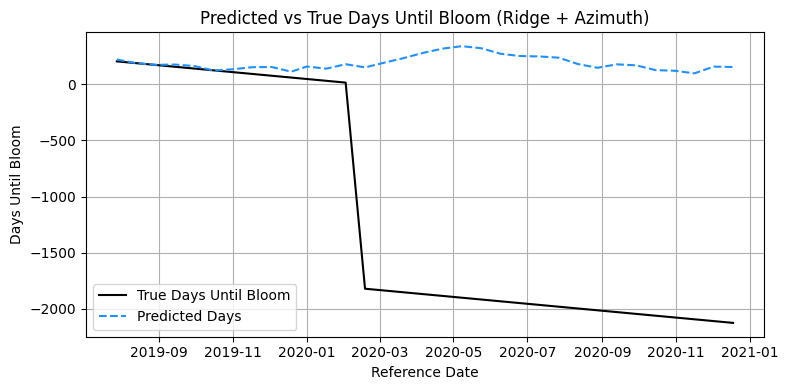

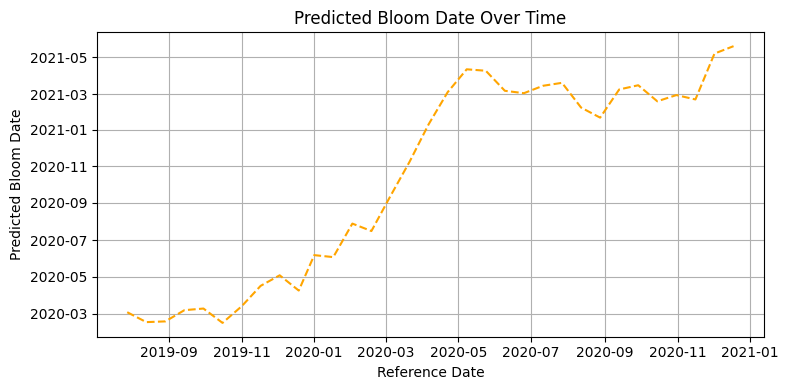

Saved a model and scaler. → C:\sehwi\NASAHackerton\data\output\saved_models


In [15]:
import os
import json
import pandas as pd
import geopandas as gpd
import numpy as np
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.linear_model import Ridge
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import matplotlib.pyplot as plt
import seaborn as sns
import joblib
import warnings
warnings.filterwarnings("ignore")

# ==============================
# CONFIGURATION
# ==============================
CONFIG = {
    "path": r"C:\sehwi\NASAHackerton\data\output",
    "feature_file": "merged.csv",
    "bloom_file": "bloom_dates.csv",
    "geojson_file": r"C:\sehwi\NASAHackerton\data\AVIRIS-Classic Coverage.geojson",
    "save_dir": "saved_models",
    "scaler_type": "minmax",
    "test_size": 0.2,
    "target": "target",
    "param_grid": {"alpha": [0.01, 0.1, 0.2, 0.5, 1.0, 10.0]},
}

# ==============================
# LOAD GEOJSON
# ==============================
def load_geojson_features(geojson_path):
    """GeoJSON 파일을 읽고 방위각 및 좌표 feature 추출"""
    gdf = gpd.read_file(geojson_path)
    
    # 방위각 컬럼 자동 탐색
    azimuth_cols = [c for c in gdf.columns if "azimuth" in c.lower() or "bearing" in c.lower() or "angle" in c.lower()]
    if not azimuth_cols:
        raise ValueError("GeoJSON에 방위각 관련 컬럼(azimuth, bearing, angle 등)이 없습니다.")
    
    az_col = azimuth_cols[0]
    gdf = gdf.rename(columns={az_col: "azimuth"})
    
    # 좌표 중심 추출
    if "geometry" in gdf.columns:
        gdf["lon"] = gdf.geometry.centroid.x
        gdf["lat"] = gdf.geometry.centroid.y
    
    geo_features = gdf[["lat", "lon", "azimuth"]]
    return geo_features

# ==============================
# LOAD & MERGE DATA
# ==============================
def load_and_merge_data(config):
    feature_path = os.path.join(config["path"], config["feature_file"])
    bloom_path = os.path.join(config["path"], config["bloom_file"])

    features_df = pd.read_csv(feature_path)
    bloom_df = pd.read_csv(bloom_path)

    geo_df = load_geojson_features(config["geojson_file"])
    # 인덱스 기반 병합 (필요시 spatial join으로 변경 가능)
    merged_df = pd.concat([features_df.reset_index(drop=True),
                           geo_df.reindex(range(len(features_df)))], axis=1)
    
    print(f"GeoJSON feature 병합 완료 (shape: {merged_df.shape})")
    print(f"포함된 feature 예시:\n{merged_df[['lat','lon','azimuth']].head()}")
    return merged_df, bloom_df

# ==============================
# TARGET 생성
# ==============================
def get_next_bloom_diff(ref_date, future_dates):
    future = future_dates[future_dates > ref_date]
    if not future.empty:
        return (future.min() - ref_date).days
    else:
        first_next_year = future_dates.min() + pd.DateOffset(years=1)
        return (first_next_year - ref_date).days

def create_target(features_df, bloom_df, config):
    features_df["date"] = pd.to_datetime(features_df["date"])
    bloom_df["bloom_date"] = pd.to_datetime(bloom_df["bloom_date"])
    features_df[config["target"]] = features_df["date"].apply(
        lambda x: get_next_bloom_diff(x, bloom_df["bloom_date"])
    )
    return features_df


# ==============================
# 학습 파이프라인
# ==============================
def train_model_pipeline(config):
    features_df, bloom_df = load_and_merge_data(config)
    features_df = create_target(features_df, bloom_df, config)

    feature_cols = [c for c in features_df.columns if c not in ["date", config["target"], "geometry"]]
    X = features_df[feature_cols].select_dtypes(include=[np.number])
    y = features_df[config["target"]]

    # Scaling
    scaler = MinMaxScaler() if config["scaler_type"] == "minmax" else StandardScaler()
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=config["test_size"], shuffle=False)
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)

    # Ridge + GridSearchCV
    grid = GridSearchCV(Ridge(), config["param_grid"], cv=5)
    grid.fit(X_train_scaled, y_train)
    best_model = grid.best_estimator_

    y_pred = best_model.predict(X_test_scaled)
    mae = mean_absolute_error(y_test, y_pred)
    rmse = np.sqrt(mean_squared_error(y_test, y_pred))
    r2 = r2_score(y_test, y_pred)
    print(f"Best Ridge α={grid.best_params_['alpha']:.3f} | MAE={mae:.2f}, RMSE={rmse:.2f}, R²={r2:.4f}")

    # 날짜로 변환
    test_dates = features_df.iloc[len(X_train):]["date"].reset_index(drop=True)
    pred_bloom_date = test_dates + pd.to_timedelta(y_pred, unit="D")

    result_df = pd.DataFrame({
        "date": test_dates,
        "pred_days": y_pred,
        "pred_bloom_date": pred_bloom_date,
        "true_days_until_bloom": y_test.values
    })

    # 그래프 시각화
    plt.figure(figsize=(8, 4))
    plt.plot(result_df["date"], result_df["true_days_until_bloom"], label="True Days Until Bloom", color="black")
    plt.plot(result_df["date"], result_df["pred_days"], label="Predicted Days", linestyle="--", color="dodgerblue")
    plt.xlabel("Reference Date")
    plt.ylabel("Days Until Bloom")
    plt.title("Predicted vs True Days Until Bloom (Ridge + Azimuth)")
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

    plt.figure(figsize=(8, 4))
    plt.plot(result_df["date"], result_df["pred_bloom_date"], label="Predicted Bloom Date", linestyle="--", color="orange")
    plt.xlabel("Reference Date")
    plt.ylabel("Predicted Bloom Date")
    plt.title("Predicted Bloom Date Over Time")
    plt.grid(True)
    plt.tight_layout()
    plt.show()

    # 모델 저장
    save_dir = os.path.join(config["path"], config["save_dir"])
    os.makedirs(save_dir, exist_ok=True)
    joblib.dump(best_model, os.path.join(save_dir, "ridge_with_azimuth.joblib"))
    joblib.dump(scaler, os.path.join(save_dir, "scaler.joblib"))
    print(f"Saved a model and scaler. → {save_dir}")

    return result_df

# ==============================
# MAIN 실행
# ==============================
if __name__ == "__main__":
    result_df = train_model_pipeline(CONFIG)


In [ ]:
import geopandas as gpd
import pandas as pd
import numpy as np

def preprocess_geo_features(geojson_path):
    """
    GeoJSON 데이터 전처리:
    - 방위각 컬럼 정제 및 geometry에서 중심 좌표(lat/lon) 추출
    - 플로리다 지역(위도 24.5~31.0, 경도 -87.6~-79.8)만 필터링
    - NaN 및 이상치 제거
    - 위경도 정규화(lat_norm, lon_norm)
    - azimuth, lat_norm, lon_norm만 반환
    """

    # 1️ GeoJSON 로드
    gdf = gpd.read_file(geojson_path)

    # 2️ 방위각 컬럼 탐색 및 rename
    azimuth_cols = [c for c in gdf.columns if "azimuth" in c.lower() or "bearing" in c.lower() or "angle" in c.lower()]
    if azimuth_cols:
        gdf = gdf.rename(columns={azimuth_cols[0]: "azimuth"})
    else:
        gdf["azimuth"] = np.nan

    # 3️ 중심 좌표 계산
    gdf["lon"] = gdf.geometry.centroid.x
    gdf["lat"] = gdf.geometry.centroid.y

    # 4️ 플로리다 지역 필터링
    gdf = gdf[(gdf["lat"].between(24.5, 31.0)) & (gdf["lon"].between(-87.6, -79.8))]
    print(f"After filtering (florida area): {len(gdf)}")

    # 5️ azimuth를 숫자형으로 변환
    gdf["azimuth"] = pd.to_numeric(gdf["azimuth"], errors="coerce")

    # 6️ NaN 및 이상치 제거
    gdf = gdf.dropna(subset=["lat", "lon", "azimuth"])
    gdf = gdf[(gdf["azimuth"] >= 0) & (gdf["azimuth"] <= 360)]

    # 7️ 위도/경도 정규화
    gdf["lat_norm"] = (gdf["lat"] - gdf["lat"].min()) / (gdf["lat"].max() - gdf["lat"].min())
    gdf["lon_norm"] = (gdf["lon"] - gdf["lon"].min()) / (gdf["lon"].max() - gdf["lon"].min())

    # 8️ 결과 feature 선택
    processed = gdf[["lat_norm", "lon_norm", "azimuth"]].reset_index(drop=True)
    print(f"Geo feature shape: {processed.shape}")

    return processed


# -------------------------------
# 예시 실행
# -------------------------------
if __name__ == "__main__":
    geojson_path = r"C:\sehwi\NASAHackerton\data\AVIRIS-Classic Coverage.geojson"
    processed_df = preprocess_geo_features(geojson_path)
    processed_df.to_csv("processed_geo_features.csv", index=False)


플로리다 지역 필터링 후 데이터 수: 106
Geo feature shape: (106, 3)


Geo feature preprocessing complete: (106, 3)
Geo features merged successfully → applied to 161 rows
Ridge (α=1.0) → MAE=1342.71, RMSE=1699.75, R²=-1.7803


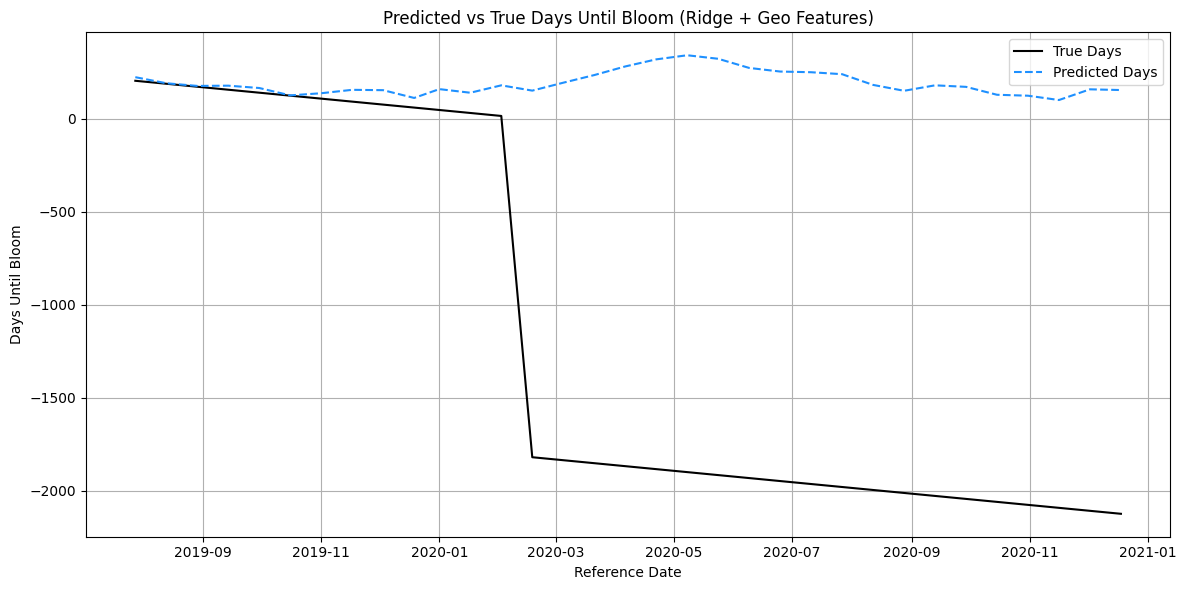

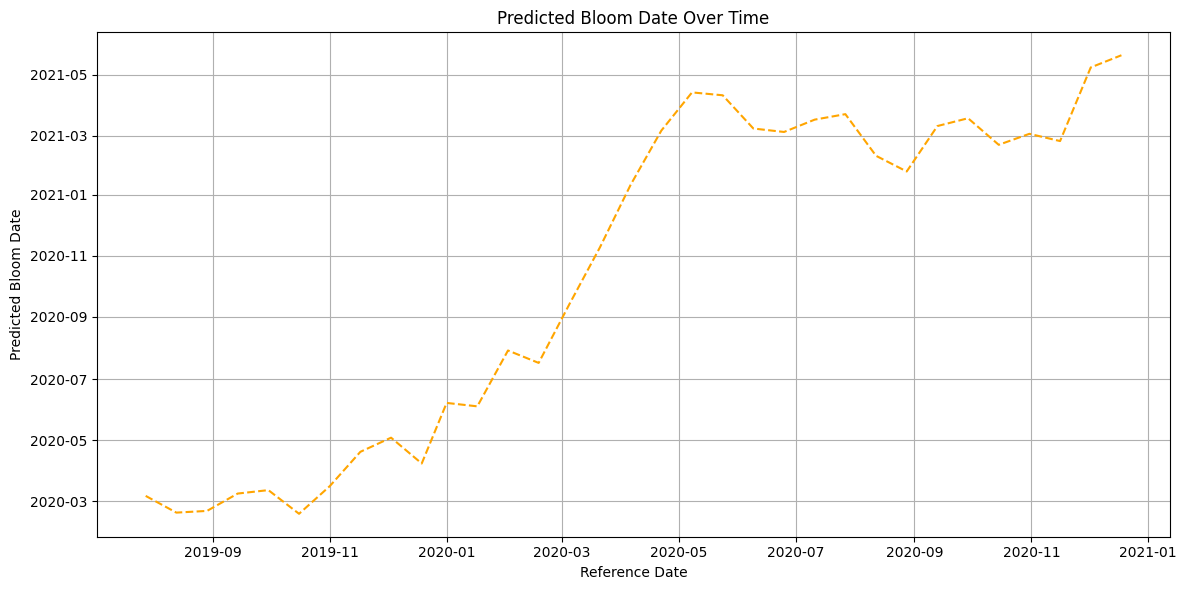

Model and scaler saved successfully → C:\sehwi\NASAHackerton\data\saved_models


In [7]:
import os
import pandas as pd
import geopandas as gpd
import numpy as np
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.linear_model import Ridge
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import matplotlib.pyplot as plt
import joblib
import warnings
warnings.filterwarnings("ignore")

# ==============================================
# CONFIGURATION
# ==============================================
CONFIG = {
    "path": r"C:\sehwi\NASAHackerton\data",
    "feature_file": r"C:\sehwi\NASAHackerton\data\output\merged.csv",
    "bloom_file": r"C:\sehwi\NASAHackerton\data\output\bloom_dates.csv",
    "geojson_file": r"C:\sehwi\NASAHackerton\data\AVIRIS-Classic Coverage.geojson",
    "save_dir": "saved_models",
    "scaler_type": "minmax",   # options: "minmax" or "standard"
    "test_size": 0.2,
    "target": "target",
    "param_grid": {"alpha": [0.01, 0.1, 0.2, 0.5, 1.0, 10.0]}
}

# ==============================================
# GEOJSON PREPROCESSING
# ==============================================
def preprocess_geo_features(geojson_path):
    """Clean and extract azimuth/coordinate features from GeoJSON."""
    gdf = gpd.read_file(geojson_path)

    # Identify azimuth-related column
    az_cols = [c for c in gdf.columns if "azimuth" in c.lower() or "bearing" in c.lower() or "angle" in c.lower()]
    if az_cols:
        gdf = gdf.rename(columns={az_cols[0]: "azimuth"})
    else:
        gdf["azimuth"] = np.nan

    # Extract centroid coordinates
    gdf["lon"] = gdf.geometry.centroid.x
    gdf["lat"] = gdf.geometry.centroid.y

    # Filter for Florida region
    gdf = gdf[(gdf["lat"].between(24.5, 31.0)) & (gdf["lon"].between(-87.6, -79.8))]

    # Convert to numeric and clean NaN values
    gdf["azimuth"] = pd.to_numeric(gdf["azimuth"], errors="coerce")
    gdf = gdf.dropna(subset=["lat", "lon", "azimuth"])
    gdf = gdf[(gdf["azimuth"] >= 0) & (gdf["azimuth"] <= 360)]

    # Normalize latitude and longitude
    gdf["lat_norm"] = (gdf["lat"] - gdf["lat"].min()) / (gdf["lat"].max() - gdf["lat"].min())
    gdf["lon_norm"] = (gdf["lon"] - gdf["lon"].min()) / (gdf["lon"].max() - gdf["lon"].min())

    processed = gdf[["lat_norm", "lon_norm", "azimuth"]].reset_index(drop=True)
    print(f"Geo feature preprocessing complete: {processed.shape}")
    return processed

# ==============================================
# LOAD AND MERGE DATA
# ==============================================
def load_and_merge_data(config):
    feature_path = os.path.join(config["path"], config["feature_file"])
    bloom_path = os.path.join(config["path"], config["bloom_file"])

    features_df = pd.read_csv(feature_path)
    bloom_df = pd.read_csv(bloom_path)

    # Load and merge geo features
    geo_df = preprocess_geo_features(config["geojson_file"])

    # Since data corresponds to a single region (Florida), broadcast average geo features to all rows
    geo_feature = geo_df.mean().to_dict()
    for k, v in geo_feature.items():
        features_df[k] = v

    print(f"Geo features merged successfully → applied to {len(features_df)} rows")
    return features_df, bloom_df

# ==============================================
# TARGET CREATION
# ==============================================
def get_next_bloom_diff(ref_date, bloom_dates):
    """Calculate days until the next bloom date from a reference date."""
    future = bloom_dates[bloom_dates > ref_date]
    if not future.empty:
        return (future.min() - ref_date).days
    else:
        first_next_year = bloom_dates.min() + pd.DateOffset(years=1)
        return (first_next_year - ref_date).days

def create_target(features_df, bloom_df, config):
    features_df["date"] = pd.to_datetime(features_df["date"])
    bloom_df["bloom_date"] = pd.to_datetime(bloom_df["bloom_date"])
    features_df[config["target"]] = features_df["date"].apply(
        lambda x: get_next_bloom_diff(x, bloom_df["bloom_date"])
    )
    return features_df

# ==============================================
# TRAINING AND EVALUATION
# ==============================================
def train_model_pipeline(config):
    features_df, bloom_df = load_and_merge_data(config)
    features_df = create_target(features_df, bloom_df, config)

    feature_cols = [c for c in features_df.columns if c not in ["date", config["target"], "geometry"]]
    X = features_df[feature_cols].select_dtypes(include=[np.number])
    y = features_df[config["target"]]

    # Split and scale data
    scaler = MinMaxScaler() if config["scaler_type"] == "minmax" else StandardScaler()
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=config["test_size"], shuffle=False)
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)

    # Ridge regression with GridSearchCV
    grid = GridSearchCV(Ridge(), config["param_grid"], cv=5)
    grid.fit(X_train_scaled, y_train)
    best_model = grid.best_estimator_

    # Evaluate model
    y_pred = best_model.predict(X_test_scaled)
    mae = mean_absolute_error(y_test, y_pred)
    rmse = np.sqrt(mean_squared_error(y_test, y_pred))
    r2 = r2_score(y_test, y_pred)
    print(f"Ridge (α={grid.best_params_['alpha']}) → MAE={mae:.2f}, RMSE={rmse:.2f}, R²={r2:.4f}")

    # Convert predictions to bloom dates
    test_dates = features_df.iloc[len(X_train):]["date"].reset_index(drop=True)
    pred_bloom_date = test_dates + pd.to_timedelta(y_pred, unit="D")

    result_df = pd.DataFrame({
        "date": test_dates,
        "pred_days": y_pred,
        "pred_bloom_date": pred_bloom_date,
        "true_days_until_bloom": y_test.values
    })

    # ==============================================
    # VISUALIZATION
    # ==============================================
    plt.figure(figsize=(12, 6))
    plt.plot(result_df["date"], result_df["true_days_until_bloom"], label="True Days", color="black")
    plt.plot(result_df["date"], result_df["pred_days"], label="Predicted Days", linestyle="--", color="dodgerblue")
    plt.xlabel("Reference Date")
    plt.ylabel("Days Until Bloom")
    plt.title("Predicted vs True Days Until Bloom (Ridge + Geo Features)")
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

    plt.figure(figsize=(12, 6))
    plt.plot(result_df["date"], result_df["pred_bloom_date"], label="Predicted Bloom Date", linestyle="--", color="orange")
    plt.xlabel("Reference Date")
    plt.ylabel("Predicted Bloom Date")
    plt.title("Predicted Bloom Date Over Time")
    plt.grid(True)
    plt.tight_layout()
    plt.show()

    # Save model and scaler
    save_dir = os.path.join(config["path"], config["save_dir"])
    os.makedirs(save_dir, exist_ok=True)
    joblib.dump(best_model, os.path.join(save_dir, "ridge_with_geo.joblib"))
    joblib.dump(scaler, os.path.join(save_dir, "scaler.joblib"))
    print(f"Model and scaler saved successfully → {save_dir}")

    return result_df

# ==============================================
# MAIN
# ==============================================
if __name__ == "__main__":
    result_df = train_model_pipeline(CONFIG)
